## Example of how to convert a measured transient into the Frequency domain

First, we import all modules that we need. ```Random``` and ```Distributions``` to generate synthetic noise, ```Plots``` to display results and ```LinearAlgebra``` for advances Matrix and Vector options.

All functionality for the conversion is implemented in ```TdipCtools```. Using ```using``` will import the module into the top namespace. Usually this should not be a problem. However, here we use ```import```, so that all functions are called with ```TdipCtools.FUNCTION()```.

In [1]:
using Random
using Distributions
using Plots
using LinearAlgebra
import TdipCtools

We start by generating the synthetic data in the time domain. As an example, we consider a simple Debye transient.

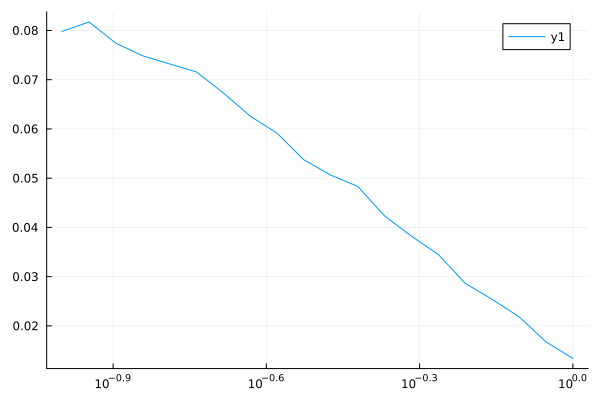

In [2]:
timesteps = 10.0 .^ (range(-1, 0, 20)) # generate 20 synthetic time steps

tau = 0.5 # relaxation time
r0 = 1.0 # dc measurement
chargeability = 0.1 # chargeability
gamma = r0 * chargeability # product of dc measurement and chargeability

std = 0.001 # absolute standard deviation of measurements on transient
Random.seed!(1000)
noise = Normal(0, std)
noise_realization = rand(noise, length(timesteps)) # draw noise realization from normal distribution
d = TdipCtools.debyeResponseTimeDomain(timesteps, gamma, tau) # generate clean transient
d = d .+ noise_realization # generate synthetic data by adding the noise realization

Cinv = Matrix{Float64}(I, (length(d), length(d))) .* (std^-2) # create the inverse data covariance matrix as a diagonal
                                                                # matrix with squared standard deviations on diagonal.

plot(timesteps, d, xscale=:log10) # plot the result

For convenience, much of the functionality can be accessed in an easy way by using the ```TdipCtools.Manager``` for single transients and the ```TdipCtools.TomoManager``` for multiple transients. ``` TdipCtools.initializeManager``` returns the data type ```Manager```, which holds all important information on the (converted) transient and is modified later.

In [3]:
manager = TdipCtools.initializeManager(d, timesteps, Cinv);

After ```manager``` was initialized, we can pass it to ```TdipCtools.occamManager!``` or ```TdipCtools.debyeManager!``` to perform the Debye decomposition with adapted or fixed regularization strength. The 1D grid of relaxation times is set automatically and can be accessed via ```Manager.tau_grid```. The result of the Debye decomposition, namely the log relaxation time distribution, is saved in ```Manager.m```. Before running the Debye decomposition, ```Manager.m``` is initialized with ```nothing```.

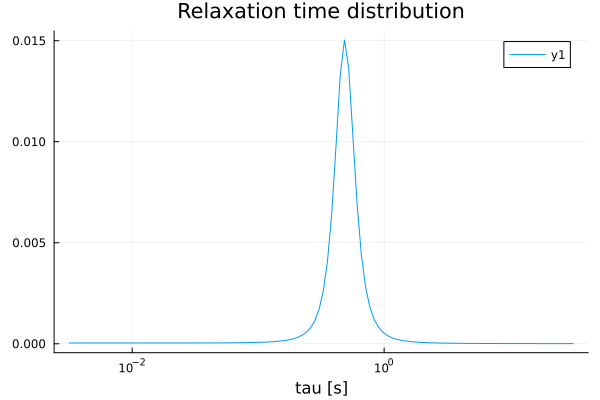

In [4]:
TdipCtools.occamManager!(manager)
plot(manager.tau_grid, exp.(manager.m), xscale=:log10, title="Relaxation time distribution", xlabel="tau [s]")

After having run the Debye decomoposition, we can now extract spectral information at the frequencies we are interested in.

In [5]:
freqs = 10.0 .^ (range(-3, 3, 200)) # Define frequencies of interest
TdipCtools.setFrequenciesManager!(manager, freqs) # set frequencies of interest within the Manager.
spectrum = TdipCtools.spectrumManager(manager); # extract the spectrum at set frequencies

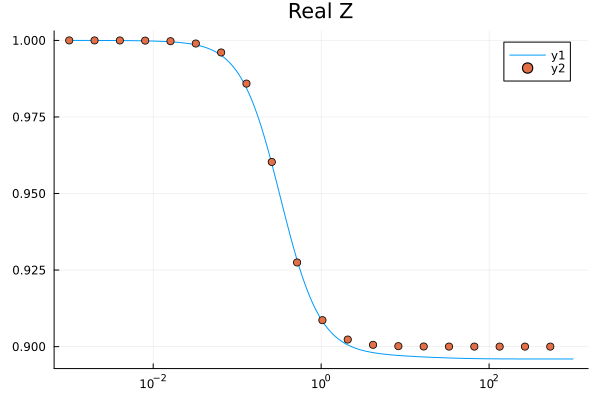

In [6]:
theoretical_freqs = freqs[1:10:end]
theoretical_spectrum = TdipCtools.decompositionResponseFrequencyDomain(theoretical_freqs * 2 * pi, Float64[gamma],
    Float64[tau], r0) # here we calculate the theoretical spectrum for comparison

# plot real part
p = plot(freqs, real(spectrum), xscale=:log10, title="Real Z")
scatter!(p, theoretical_freqs, real(theoretical_spectrum))

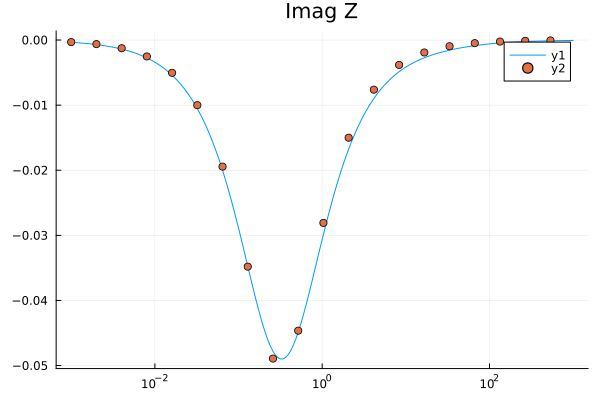

In [7]:
# plot imag part
p = plot(freqs, imag(spectrum), xscale=:log10, title="Imag Z")
scatter!(p, theoretical_freqs, imag(theoretical_spectrum))